In [1]:
import sys
sys.path.append('..')  # 添加项目根目录到路径
import torch  # 添加这行
import numpy as np
import matplotlib.pyplot as plt
import wfdb
from scipy import signal as sig
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder
from collections import Counter
import os
import pickle
from imblearn.over_sampling import SMOTE
import numpy as np
import matplotlib.pyplot as plt
import wfdb

# 暂时不导入自定义模块，我们直接在notebook中定义需要的函数
def plot_ecg_signal(signal, sampling_rate=360, title="ECG Signal"):
    """绘制ECG信号"""
    time = np.arange(len(signal)) / sampling_rate
    plt.figure(figsize=(15, 5))
    plt.plot(time, signal)
    plt.xlabel('Time (s)')
    plt.ylabel('Amplitude')
    plt.title(title)
    plt.grid(True)
    plt.show()

print("Libraries imported successfully!")

Libraries imported successfully!


In [2]:
# 设置数据路径
record_path = '../data/raw/100'  # MIT-BIH的100号记录

try:
    # 读取记录
    record = wfdb.rdrecord(record_path)
    # 读取标注
    annotation = wfdb.rdann(record_path, 'atr')
    
    print("数据基本信息：")
    print(f"记录长度: {len(record.p_signal)} 个采样点")
    print(f"采样频率: {record.fs} Hz")
    print(f"导联数量: {record.n_sig}")
    print(f"信号形状: {record.p_signal.shape}")
    print("\n标注信息：")
    print(f"标注类型: {set(annotation.symbol)}")
    print(f"标注数量: {len(annotation.symbol)}")
    
except FileNotFoundError:
    print("数据文件未找到，请确保已下载MIT-BIH数据集到 data/raw 目录")

数据基本信息：
记录长度: 650000 个采样点
采样频率: 360 Hz
导联数量: 2
信号形状: (650000, 2)

标注信息：
标注类型: {'+', 'V', 'A', 'N'}
标注数量: 2274


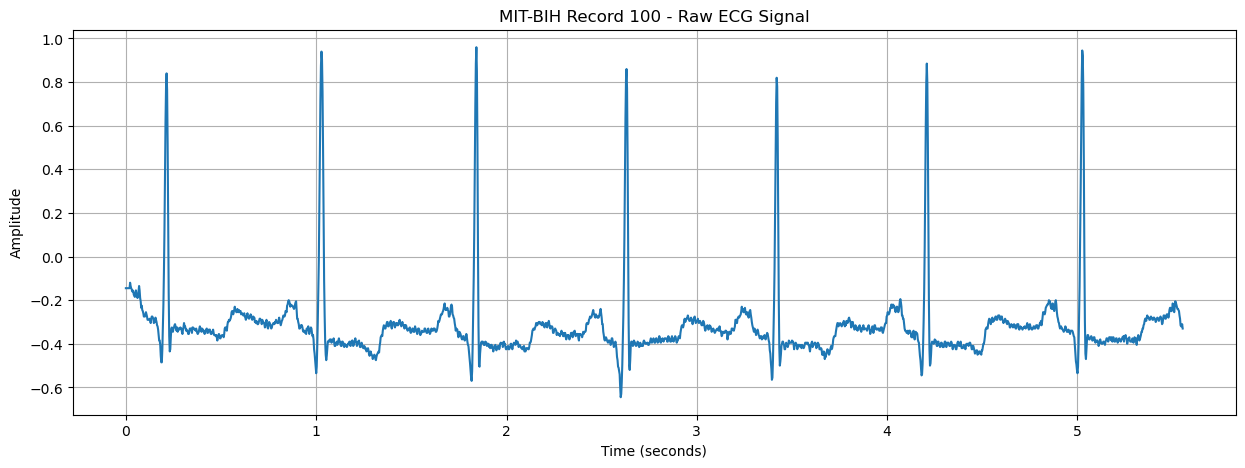


Annotations in this signal segment:
Position: 0.05s, Type: +
Position: 0.21s, Type: N
Position: 1.03s, Type: N
Position: 1.84s, Type: N
Position: 2.63s, Type: N
Position: 3.42s, Type: N
Position: 4.21s, Type: N
Position: 5.03s, Type: N


In [3]:
# 选择第一导联的前2000个采样点进行可视化
signal = record.p_signal[:2000, 0]  # 第一导联
time = np.arange(len(signal)) / record.fs  # 转换为时间轴（秒）

plt.figure(figsize=(15, 5))
plt.plot(time, signal)
plt.title('MIT-BIH Record 100 - Raw ECG Signal')
plt.xlabel('Time (seconds)')
plt.ylabel('Amplitude')
plt.grid(True)
plt.show()

# 打印这段信号中的标注
print("\nAnnotations in this signal segment:")
for i, (sample, symbol) in enumerate(zip(annotation.sample, annotation.symbol)):
    if sample < 2000:  # 只显示前2000个采样点内的标注
        print(f"Position: {sample/record.fs:.2f}s, Type: {symbol}")

Beat Type Distribution:
+: 1 beats (0.0%)
N: 2239 beats (98.5%)
A: 33 beats (1.5%)
V: 1 beats (0.0%)


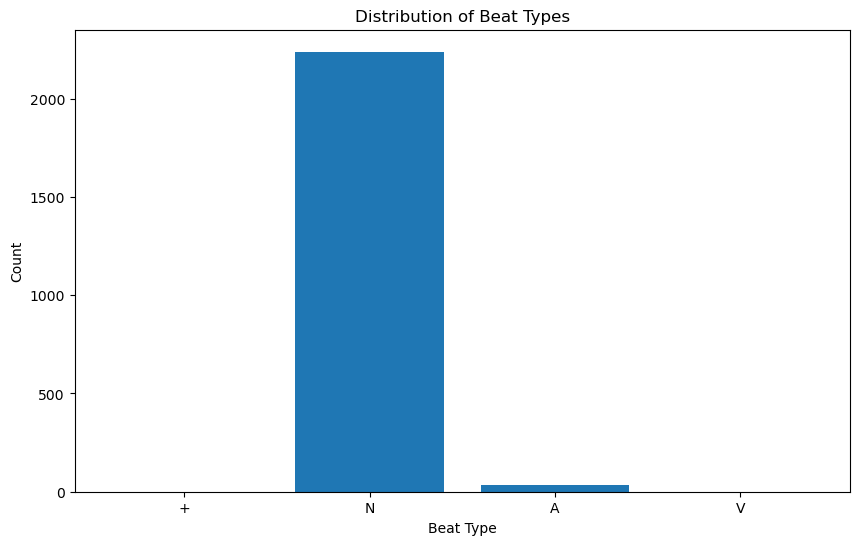

In [4]:
# 统计各类型心拍的数量
from collections import Counter

beat_types = Counter(annotation.symbol)
print("Beat Type Distribution:")
for beat_type, count in beat_types.items():
    print(f"{beat_type}: {count} beats ({count/len(annotation.symbol)*100:.1f}%)")

# 可视化心拍类型分布
plt.figure(figsize=(10, 6))
plt.bar(beat_types.keys(), beat_types.values())
plt.title('Distribution of Beat Types')
plt.xlabel('Beat Type')
plt.ylabel('Count')
plt.show()

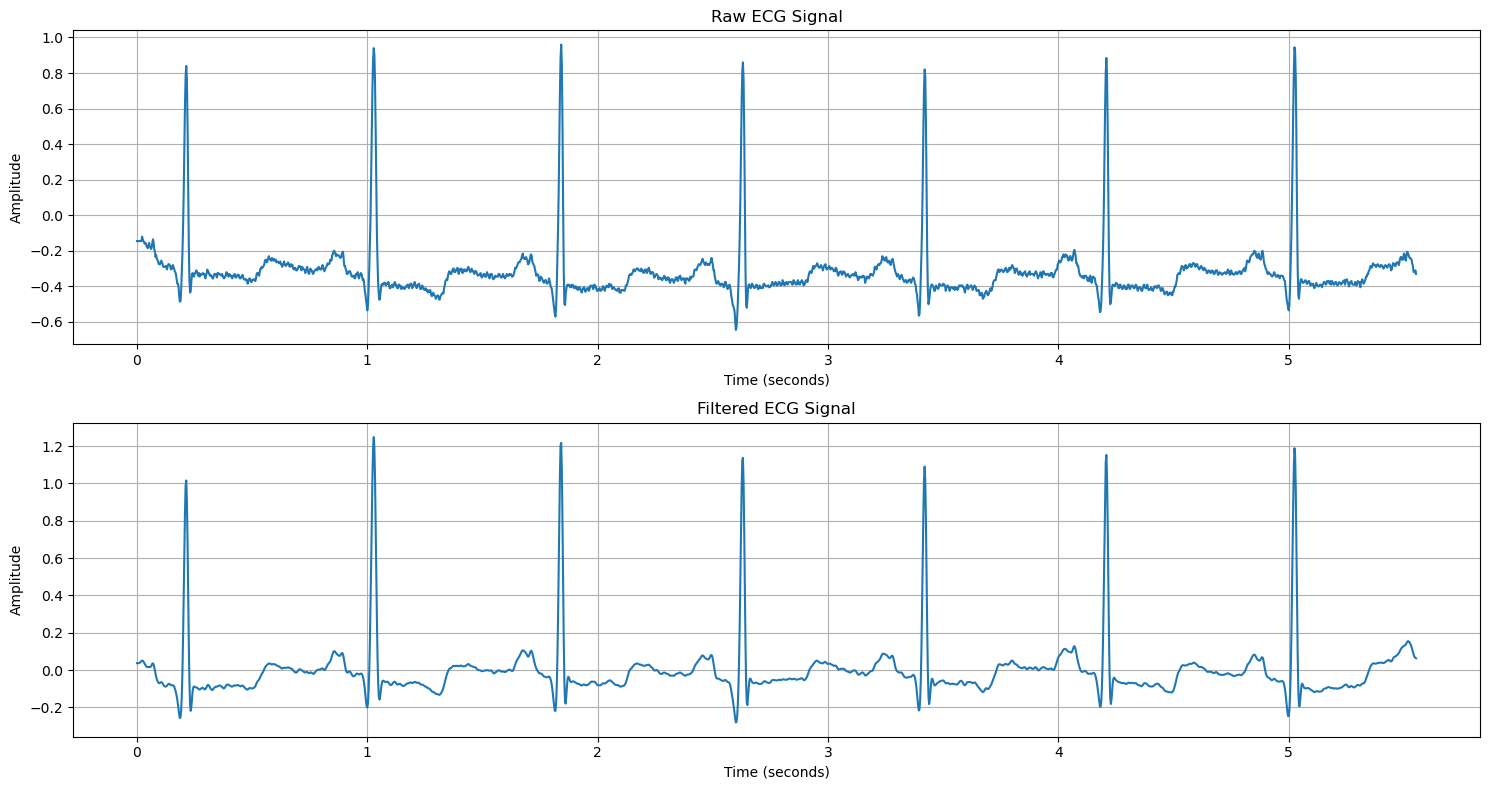

In [5]:
from scipy import signal

def filter_ecg(ecg_signal, fs=360):
    """
    对ECG信号进行带通滤波
    fs: 采样频率
    """
    # 带通滤波器 0.5-45Hz
    b, a = signal.butter(3, [0.5, 45], btype='band', fs=fs)
    filtered_signal = signal.filtfilt(b, a, ecg_signal)
    return filtered_signal

# 对第一导联信号进行滤波
raw_signal = record.p_signal[:2000, 0]
filtered_signal = filter_ecg(raw_signal)

# 对比可视化
plt.figure(figsize=(15, 8))

plt.subplot(2, 1, 1)
plt.plot(time, raw_signal)
plt.title('Raw ECG Signal')
plt.xlabel('Time (seconds)')
plt.ylabel('Amplitude')
plt.grid(True)

plt.subplot(2, 1, 2)
plt.plot(time, filtered_signal)
plt.title('Filtered ECG Signal')
plt.xlabel('Time (seconds)')
plt.ylabel('Amplitude')
plt.grid(True)

plt.tight_layout()
plt.show()

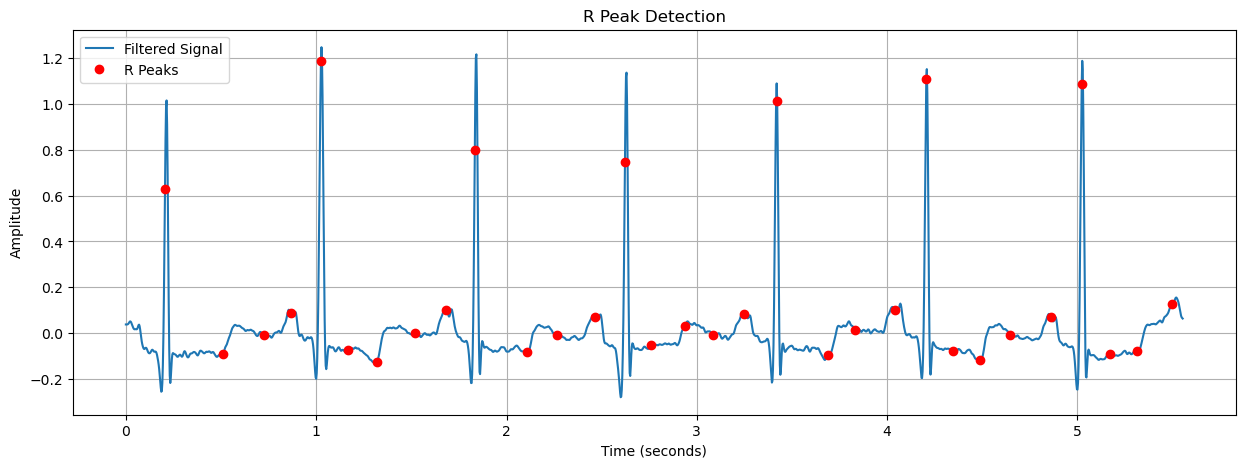


Number of R peaks detected: 31


In [6]:
from scipy import signal as sig  # 重命名为sig避免冲突

def detect_r_peaks(ecg_signal, fs=360):
    """
    R峰检测
    """
    # 差分
    diff_signal = np.diff(ecg_signal)
    
    # 平方
    squared_signal = diff_signal ** 2
    
    # 移动平均
    window_size = int(0.1 * fs)  # 100ms窗口
    moving_avg = np.convolve(squared_signal, np.ones(window_size)/window_size, mode='same')
    
    # 寻找峰值
    peaks, _ = sig.find_peaks(moving_avg, distance=50)  # 最小间距约140ms
    
    return peaks

# 检测R峰
r_peaks = detect_r_peaks(filtered_signal)

# 可视化R峰检测结果
plt.figure(figsize=(15, 5))
plt.plot(time, filtered_signal, label='Filtered Signal')
plt.plot(time[r_peaks], filtered_signal[r_peaks], 'ro', label='R Peaks')
plt.title('R Peak Detection')
plt.xlabel('Time (seconds)')
plt.ylabel('Amplitude')
plt.legend()
plt.grid(True)
plt.show()

print(f"\nNumber of R peaks detected: {len(r_peaks)}")

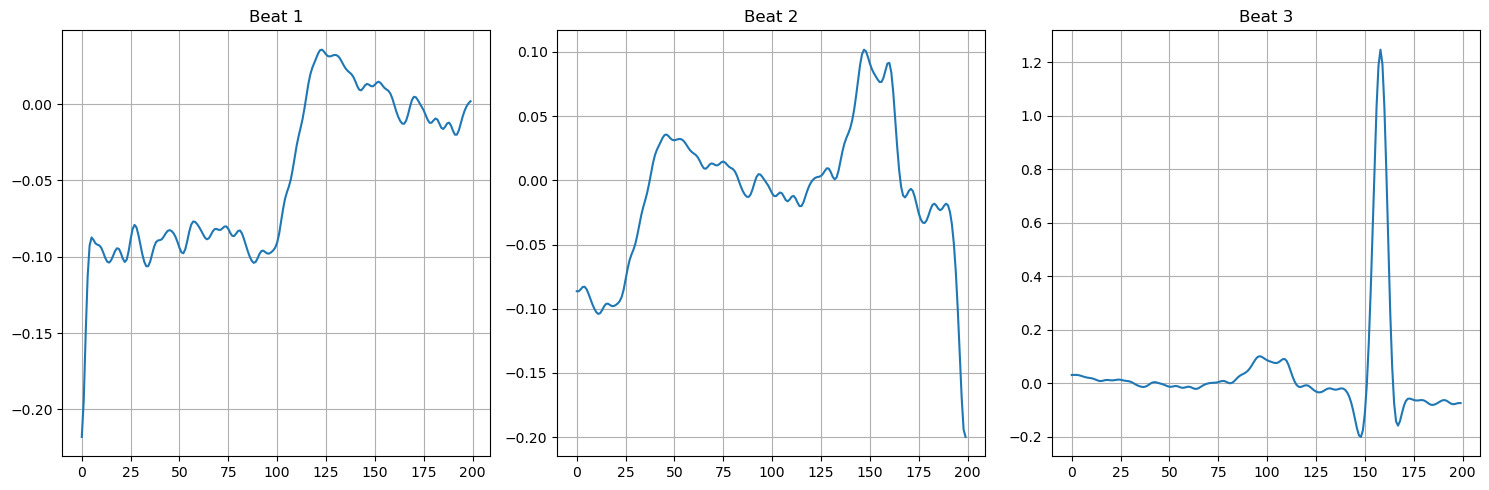


Number of segmented beats: 28
Each beat segment shape: (200,)


In [7]:
def segment_beats(signal, peaks, window_size=100):
    """
    根据R峰位置分割心拍
    window_size: R峰前后的采样点数
    """
    segments = []
    for peak in peaks:
        if peak - window_size >= 0 and peak + window_size < len(signal):
            segment = signal[peak-window_size:peak+window_size]
            segments.append(segment)
    return np.array(segments)

# 分割心拍
beat_segments = segment_beats(filtered_signal, r_peaks)

# 可视化几个心拍
plt.figure(figsize=(15, 5))
for i in range(min(3, len(beat_segments))):
    plt.subplot(1, 3, i+1)
    plt.plot(beat_segments[i])
    plt.title(f'Beat {i+1}')
    plt.grid(True)

plt.tight_layout()
plt.show()

print(f"\nNumber of segmented beats: {len(beat_segments)}")
print(f"Each beat segment shape: {beat_segments[0].shape}")

In [8]:
# 将标注与R峰位置对应
def match_beats_annotations(r_peaks, annotation_samples, annotation_symbols):
    """
    将R峰位置与最近的标注对应
    """
    beat_labels = []
    for peak in r_peaks:
        # 找到最近的标注
        closest_idx = np.argmin(np.abs(annotation_samples - peak))
        beat_labels.append(annotation_symbols[closest_idx])
    
    return beat_labels

# 获取标注
beat_labels = match_beats_annotations(r_peaks, annotation.sample, annotation.symbol)

# 显示标注统计
from collections import Counter
label_counts = Counter(beat_labels)
print("Beat annotations distribution:")
for label, count in label_counts.items():
    print(f"Type {label}: {count} beats ({count/len(beat_labels)*100:.1f}%)")

Beat annotations distribution:
Type N: 30 beats (96.8%)
Type A: 1 beats (3.2%)


In [9]:
def preprocess_beats(segments, labels, window_size=200):
    """改进的预处理函数"""
    try:
        # 1. 确保所有片段长度一致
        segments = np.array([seg[:window_size] if len(seg) > window_size 
                           else np.pad(seg, (0, window_size - len(seg))) 
                           for seg in segments])
        
        # 2. 标准化每个心拍
        scaler = StandardScaler()
        scaled_segments = np.array([scaler.fit_transform(seg.reshape(-1, 1)).ravel() 
                                  for seg in segments])
        
        # 3. 对齐R峰（确保R峰在中心位置）
        aligned_segments = []
        for seg in scaled_segments:
            try:
                r_peak_idx = np.argmax(seg)
                center = len(seg) // 2
                shift = center - r_peak_idx
                aligned_seg = np.roll(seg, shift)
                aligned_segments.append(aligned_seg)
            except Exception as e:
                print(f"Warning: R-peak alignment failed for a segment: {str(e)}")
                aligned_segments.append(seg)  # 使用原始片段
        
        # 4. 滤波去噪
        filtered_segments = np.array([filter_ecg(seg) for seg in aligned_segments])
        
        print(f"Preprocessed {len(segments)} segments")
        return filtered_segments
        
    except Exception as e:
        print(f"Error in preprocessing: {str(e)}")
        return segments  # 返回原始数据

In [10]:
def extract_features(segments):
    """提取额外的特征"""
    features = []
    for seg in segments:
        try:
            # 基本统计特征
            stats = [
                np.mean(seg),
                np.std(seg),
                np.max(seg),
                np.min(seg),
                np.median(seg),
                np.percentile(seg, 25),  # 添加四分位数
                np.percentile(seg, 75),
                np.sum(np.abs(np.diff(seg)))  # 添加变化率
            ]
            
            # RR间期特征
            peaks, properties = sig.find_peaks(seg, height=0)
            if len(peaks) > 1:
                rr_features = [
                    np.mean(np.diff(peaks)),
                    np.std(np.diff(peaks)),
                    len(peaks),  # 峰值数量
                    np.mean(properties['peak_heights'])  # 峰值高度
                ]
            else:
                rr_features = [0, 0, 0, 0]
            
            # 频域特征
            fft_features = np.abs(np.fft.fft(seg))[:10]  # 前10个频率分量
            
            # 组合所有特征
            combined = np.concatenate([seg, stats, rr_features, fft_features])
            features.append(combined)
            
        except Exception as e:
            print(f"Warning: Feature extraction failed for a segment: {str(e)}")
            # 使用零向量作为备选
            features.append(np.zeros_like(features[0]) if features else np.zeros(len(seg) + 22))
    
    return np.array(features)

In [11]:
def prepare_snn_data(X, y, test_size=0.2, val_size=0.1):
    """准备SNN训练数据"""
    try:
        # 1. 转换标签为数字
        le = LabelEncoder()
        y_encoded = le.fit_transform(y)
        
        # 2. 数据集划分（添加验证集）
        X_temp, X_test, y_temp, y_test = train_test_split(
            X, y_encoded, test_size=test_size, stratify=y_encoded, random_state=42
        )
        
        X_train, X_val, y_train, y_val = train_test_split(
            X_temp, y_temp, test_size=val_size/(1-test_size), 
            stratify=y_temp, random_state=42
        )
        
        # 3. 处理类别不平衡
        try:
            smote = SMOTE(random_state=42)
            X_train_balanced, y_train_balanced = smote.fit_resample(X_train, y_train)
        except Exception as e:
            print(f"Warning: SMOTE failed ({str(e)}). Using original data.")
            X_train_balanced, y_train_balanced = X_train, y_train
        
        # 4. 转换为PyTorch张量
        tensors = {
            'train_x': torch.FloatTensor(X_train_balanced),
            'train_y': torch.LongTensor(y_train_balanced),
            'val_x': torch.FloatTensor(X_val),
            'val_y': torch.LongTensor(y_val),
            'test_x': torch.FloatTensor(X_test),
            'test_y': torch.LongTensor(y_test)
        }
        
        # 5. 打印数据集信息
        print("\nDataset split information:")
        print(f"Training set: {len(X_train_balanced)} samples")
        print(f"Validation set: {len(X_val)} samples")
        print(f"Test set: {len(X_test)} samples")
        
        return tensors, le.classes_
        
    except Exception as e:
        print(f"Error in data preparation: {str(e)}")
        return None

In [12]:
def load_multiple_records(record_numbers=[100, 101, 102, 103, 104, 105, 106, 107, 108, 109, 
                                        111, 112, 113, 114, 115, 116, 117, 118, 119, 
                                        121, 122, 123, 124], 
                         signal_length=360000): # 修改记录范围
    all_segments = []
    all_labels = []
    
    # 添加进度显示
    total_records = len(list(record_numbers))
    processed_records = 0
    
    for record_num in record_numbers:
        record_path = f'../data/raw/{record_num}'
        try:
            # 加载记录
            record = wfdb.rdrecord(record_path)
            annotation = wfdb.rdann(record_path, 'atr')
            
            # 处理多个信号片段
            segments_for_record = []
            labels_for_record = []
            
            for start in range(0, len(record.p_signal), signal_length//4):  # 使用75%的重叠
                end = start + signal_length
                if end > len(record.p_signal):
                    break
                    
                # 处理当前信号片段
                signal = record.p_signal[start:end, 0]
                filtered_signal = filter_ecg(signal)
                r_peaks = detect_r_peaks(filtered_signal)
                
                # 调整标注位置
                valid_annotations = [(s-start, sym) for s, sym in zip(annotation.sample, annotation.symbol)
                                   if start <= s < end]
                if not valid_annotations:
                    continue
                valid_samples, valid_symbols = zip(*valid_annotations)
                
                segments = segment_beats(filtered_signal, r_peaks)
                labels = match_beats_annotations(r_peaks, valid_samples, valid_symbols)
                
                # 确保segments和labels长度一致
                min_len = min(len(segments), len(labels))
                segments = segments[:min_len]
                labels = labels[:min_len]
                
                # 过滤掉不需要的标注类型
                valid_types = ['N', 'A', 'V', 'L', 'R']  # 增加更多心拍类型
                valid_indices = [i for i, label in enumerate(labels) if label in valid_types]
                segments = [segments[i] for i in valid_indices]
                labels = [labels[i] for i in valid_indices]
                
                # 添加到当前记录的数据中
                segments_for_record.extend(segments)
                labels_for_record.extend(labels)
            
            # 对当前记录进行初步平衡（可选）
            label_counts = Counter(labels_for_record)
            if len(label_counts) >= 2:  # 至少有两种类型
                min_count = min(label_counts.values())
                max_samples_per_class = min(min_count * 5, 1000)  # 限制每类样本数
                
                balanced_segments = []
                balanced_labels = []
                
                for label in valid_types:
                    if label in label_counts:
                        indices = [i for i, l in enumerate(labels_for_record) if l == label]
                        if len(indices) > max_samples_per_class:
                            indices = np.random.choice(indices, max_samples_per_class, replace=False)
                        balanced_segments.extend([segments_for_record[i] for i in indices])
                        balanced_labels.extend([label] * len(indices))
                
                all_segments.extend(balanced_segments)
                all_labels.extend(balanced_labels)
            
            processed_records += 1
            print(f"\nRecord {record_num} ({processed_records}/{total_records}):")
            print(f"Original distribution: {Counter(labels_for_record)}")
            if len(label_counts) >= 2:
                print(f"Balanced distribution: {Counter(balanced_labels)}")
            
        except Exception as e:
            print(f"Error processing record {record_num}: {str(e)}")
            continue
    
    # 在所有数据收集完后进行全局平衡
    print("\nBefore final balancing:")
    print(Counter(all_labels))
    
    # 对整个数据集进行最终平衡
    label_counts = Counter(all_labels)
    target_count = max(min(label_counts.values()) * 5, 500)  # 增加目标样本数
    
    balanced_segments = []
    balanced_labels = []
    
    for label in valid_types:
        if label in label_counts and label_counts[label] >= 50:  # 只保留样本数足够的类别
            label_indices = [i for i, l in enumerate(all_labels) if l == label]
            if len(label_indices) >= target_count:
                selected_indices = np.random.choice(label_indices, target_count, replace=False)
            else:
                selected_indices = np.random.choice(label_indices, target_count, replace=True)
            
            balanced_segments.extend([all_segments[i] for i in selected_indices])
            balanced_labels.extend([label] * target_count)
    
    print("\nAfter final balancing:")
    print(Counter(balanced_labels))
    
    return np.array(balanced_segments), np.array(balanced_labels)


Record 100 (1/25):
Original distribution: Counter({'N': 22455, 'A': 335, 'V': 4})
Balanced distribution: Counter({'N': 20, 'A': 20, 'V': 4})

Record 101 (2/25):
Original distribution: Counter({'N': 22051, 'A': 34})
Balanced distribution: Counter({'N': 170, 'A': 34})

Record 102 (3/25):
Original distribution: Counter({'N': 398, 'V': 21})
Balanced distribution: Counter({'N': 105, 'V': 21})

Record 103 (4/25):
Original distribution: Counter({'N': 19037, 'A': 25})
Balanced distribution: Counter({'N': 125, 'A': 25})

Record 104 (5/25):
Original distribution: Counter({'N': 1345, 'V': 18})
Balanced distribution: Counter({'N': 90, 'V': 18})

Record 105 (6/25):
Original distribution: Counter({'N': 20406, 'V': 291})
Balanced distribution: Counter({'N': 1000, 'V': 291})

Record 106 (7/25):
Original distribution: Counter({'N': 14619, 'V': 4173})
Balanced distribution: Counter({'N': 1000, 'V': 1000})

Record 107 (8/25):
Original distribution: Counter({'V': 475})

Record 108 (9/25):
Original distri

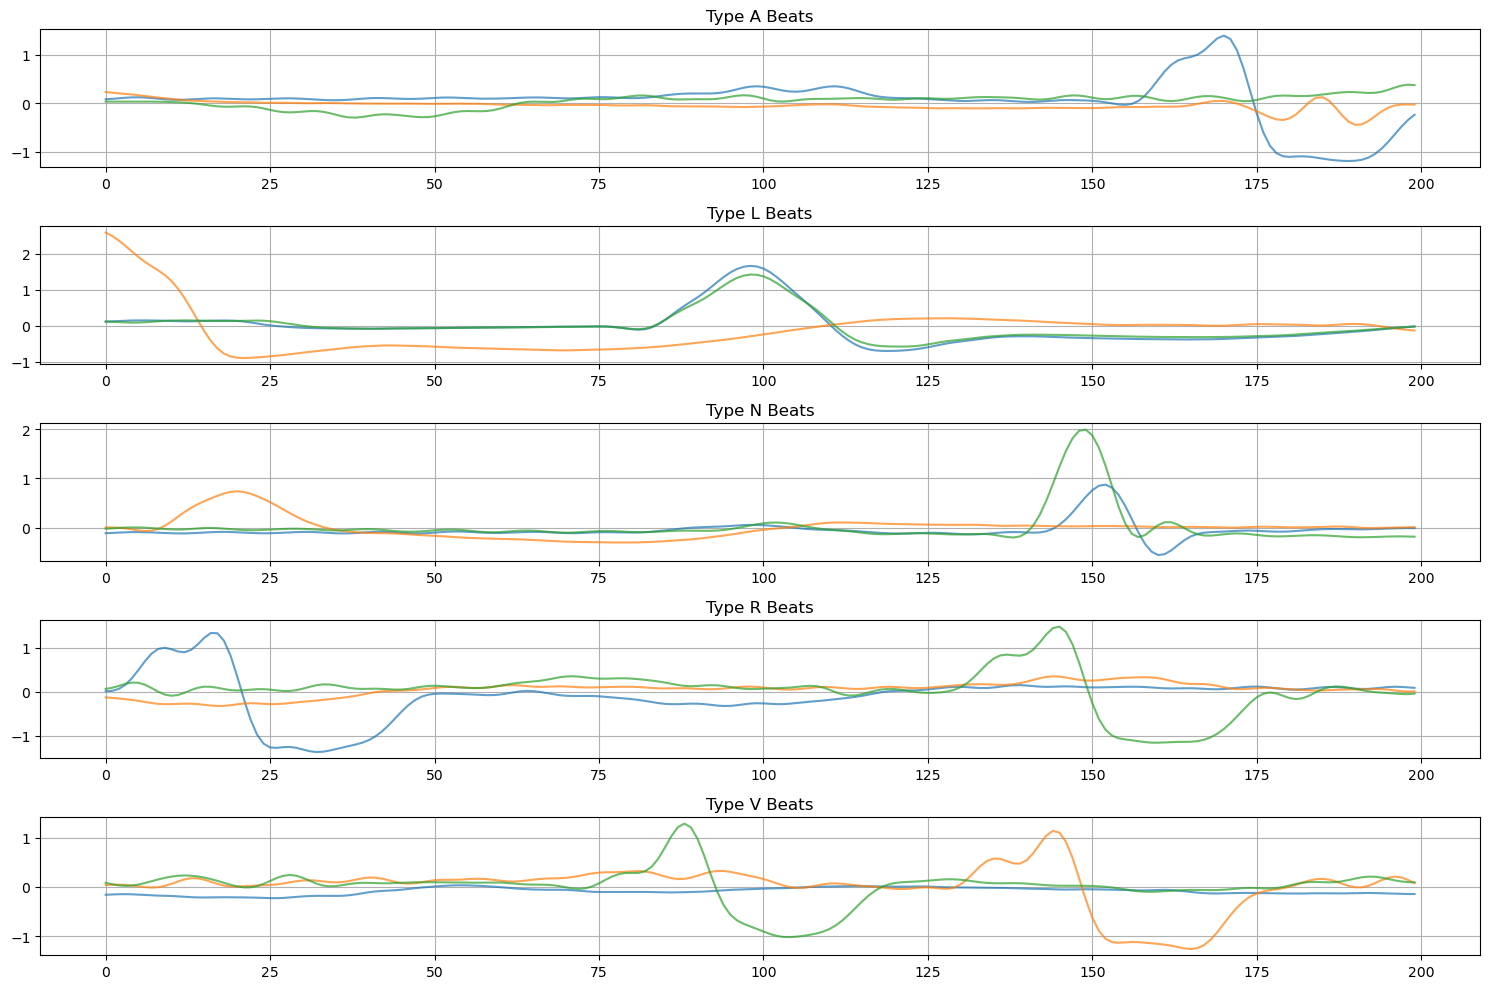

Preprocessed 20250 segments

Dataset split information:
Training set: 16200 samples
Validation set: 2026 samples
Test set: 2025 samples

Data processed and saved successfully!
Final feature shape: (20250, 222)

Class distribution in training set:
Counter({4: 3240, 1: 3240, 0: 3240, 3: 3240, 2: 3240})


In [13]:
# 加载和处理数据
X_all, y_all = load_multiple_records(record_numbers=range(100, 125))

# 检查数据分布
print("\nFinal dataset:")
print(f"Number of segments: {len(X_all)}")
print(f"Number of labels: {len(y_all)}")
print("\nClass distribution:")
for label, count in Counter(y_all).items():
    print(f"Type {label}: {count} ({count/len(y_all)*100:.1f}%)")

# 可视化一些样本（可选）
plt.figure(figsize=(15, 10))
for i, label in enumerate(np.unique(y_all)):
    plt.subplot(len(np.unique(y_all)), 1, i+1)
    mask = y_all == label
    for j in range(min(3, sum(mask))):
        plt.plot(X_all[mask][j], alpha=0.7)
    plt.title(f'Type {label} Beats')
    plt.grid(True)
plt.tight_layout()
plt.show()

# 数据预处理和特征提取
X_processed = preprocess_beats(X_all, y_all)
X_features = extract_features(X_processed)

# 准备SNN训练数据
train_data = prepare_snn_data(X_features, y_all, test_size=0.1, val_size=0.1)

# 保存处理后的数据
if train_data is not None:
    processed_data = {
        'X_train': train_data[0]['train_x'],
        'y_train': train_data[0]['train_y'],
        'X_val': train_data[0]['val_x'],
        'y_val': train_data[0]['val_y'],
        'X_test': train_data[0]['test_x'],
        'y_test': train_data[0]['test_y'],
        'classes': train_data[1],
        'sampling_rate': 360,  # MIT-BIH的采样率
        'feature_shape': X_features.shape[1:]
    }
    
    os.makedirs('../data/processed', exist_ok=True)
    with open('../data/processed/processed_data.pkl', 'wb') as f:
        pickle.dump(processed_data, f)
    
    print("\nData processed and saved successfully!")
    print(f"Final feature shape: {X_features.shape}")
    print("\nClass distribution in training set:")
    print(Counter(train_data[0]['train_y'].numpy()))

In [28]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class SNN(nn.Module):
    def __init__(self, input_size=222, hidden_size=256, num_classes=5):
        super(SNN, self).__init__()
        
        # 特征提取层
        self.feature_extractor = nn.Sequential(
            nn.Linear(input_size, hidden_size),
            nn.BatchNorm1d(hidden_size, track_running_stats=True),  # 修正BatchNorm
            nn.ReLU(),
            nn.Dropout(0.4),
            nn.Linear(hidden_size, hidden_size//2),
            nn.BatchNorm1d(hidden_size//2, track_running_stats=True),  # 修正BatchNorm
            nn.ReLU(),
            nn.Dropout(0.4)
        )
        
        # 度量学习层
        self.metric_layer = nn.Sequential(
            nn.Linear(hidden_size//2, hidden_size//4),
            nn.BatchNorm1d(hidden_size//4, track_running_stats=True),  # 修正BatchNorm
            nn.ReLU(),
            nn.Linear(hidden_size//4, hidden_size//8)
        )
        
        # 分类层
        self.classifier = nn.Sequential(
            nn.Linear(hidden_size//8, hidden_size//16),
            nn.ReLU(),
            nn.Linear(hidden_size//16, num_classes)
        )
        
        # 初始化权重
        self.apply(self._init_weights)
        
    def _init_weights(self, m):
        if isinstance(m, nn.Linear):
            nn.init.kaiming_normal_(m.weight, mode='fan_out', nonlinearity='relu')
            if m.bias is not None:
                nn.init.constant_(m.bias, 0)
        elif isinstance(m, nn.BatchNorm1d):
            nn.init.constant_(m.weight, 1)
            nn.init.constant_(m.bias, 0)
    
    def forward_one(self, x):
        features = self.feature_extractor(x)
        embeddings = self.metric_layer(features)
        logits = self.classifier(embeddings)
        return embeddings, logits
    
    def forward(self, x1, x2=None):
        embedding1, logits1 = self.forward_one(x1)
        
        if x2 is not None:
            embedding2, logits2 = self.forward_one(x2)
            return embedding1, embedding2, logits1, logits2
        
        return embedding1, logits1

# 定义损失函数
class CombinedLoss(nn.Module):
    def __init__(self, margin=1.0):
        super(CombinedLoss, self).__init__()
        self.margin = margin
        self.ce_loss = nn.CrossEntropyLoss()
        
    def forward(self, embeddings1, embeddings2, logits1, logits2, labels1, labels2):
        # 分类损失
        ce_loss = self.ce_loss(logits1, labels1) + self.ce_loss(logits2, labels2)
        
        # 对比损失
        distance = F.pairwise_distance(embeddings1, embeddings2)
        same_class = (labels1 == labels2).float()
        contrastive_loss = same_class * distance.pow(2) + \
                          (1 - same_class) * F.relu(self.margin - distance).pow(2)
        
        return ce_loss + 0.5 * contrastive_loss.mean()

In [29]:
import torch
from torch.utils.data import Dataset, DataLoader
import numpy as np
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm

class ECGDataset(Dataset):
    def __init__(self, features, labels, augment=False):
        self.features = torch.FloatTensor(features)
        self.labels = torch.LongTensor(labels)
        self.augment = augment
        
    def __len__(self):
        return len(self.features)
    
    def augment_signal(self, x):
        # 添加随机噪声
        if torch.rand(1) < 0.5:
            x = x + torch.randn_like(x) * 0.01
        
        # 随机缩放
        if torch.rand(1) < 0.5:
            scale = torch.randn(1) * 0.1 + 1
            x = x * scale
            
        return x
    
    def __getitem__(self, idx):
        x1 = self.features[idx]
        y1 = self.labels[idx]
        
        # 对训练数据进行增强
        if self.augment:
            x1 = self.augment_signal(x1)
        
        # 选择同类样本的概率更高
        if torch.rand(1) < 0.7:
            same_class_indices = torch.where(self.labels == y1)[0]
            idx2 = same_class_indices[torch.randint(len(same_class_indices), (1,))]
        else:
            idx2 = torch.randint(len(self.features), (1,))
            
        x2 = self.features[idx2]
        y2 = self.labels[idx2]
        
        if self.augment:
            x2 = self.augment_signal(x2)
            
        return {
            'x1': x1,
            'x2': x2,
            'y1': y1,
            'y2': y2
        }
def create_dataloaders(processed_data, batch_size=128):
    # 创建数据集，只对训练集进行增强
    train_dataset = ECGDataset(processed_data['X_train'], processed_data['y_train'], augment=True)
    val_dataset = ECGDataset(processed_data['X_val'], processed_data['y_val'], augment=False)
    test_dataset = ECGDataset(processed_data['X_test'], processed_data['y_test'], augment=False)
    
    # 创建数据加载器，设置 num_workers=0 禁用多进程
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=0)
    val_loader = DataLoader(val_dataset, batch_size=batch_size, num_workers=0)
    test_loader = DataLoader(test_dataset, batch_size=batch_size, num_workers=0)
    
    return train_loader, val_loader, test_loader

In [30]:
class EarlyStopping:
    def __init__(self, patience=10, min_delta=0.001):
        self.patience = patience
        self.min_delta = min_delta
        self.counter = 0
        self.best_loss = None
        self.early_stop = False
        
    def step(self, val_loss):
        if self.best_loss is None:
            self.best_loss = val_loss
        elif val_loss > self.best_loss - self.min_delta:
            self.counter += 1
            if self.counter >= self.patience:
                self.early_stop = True
        else:
            self.best_loss = val_loss
            self.counter = 0
        
        return self.early_stop

In [31]:
def train_epoch(model, train_loader, criterion, optimizer, device):
    model.train()
    total_loss = 0
    all_preds = []
    all_labels = []
    
    for batch in tqdm(train_loader, desc='Training'):
        x1, x2 = batch['x1'].to(device), batch['x2'].to(device)
        y1, y2 = batch['y1'].to(device), batch['y2'].to(device)
        
        # 前向传播
        emb1, emb2, logits1, logits2 = model(x1, x2)
        
        # 计算损失
        loss = criterion(emb1, emb2, logits1, logits2, y1, y2)
        
        # 反向传播
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        total_loss += loss.item()
        
        # 收集预测结果
        _, preds = torch.max(logits1, 1)
        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(y1.cpu().numpy())
    
    return total_loss / len(train_loader), all_preds, all_labels

def evaluate(model, data_loader, criterion, device):
    model.eval()
    total_loss = 0
    all_preds = []
    all_labels = []
    
    with torch.no_grad():
        for batch in data_loader:
            x1, x2 = batch['x1'].to(device), batch['x2'].to(device)
            y1, y2 = batch['y1'].to(device), batch['y2'].to(device)
            
            emb1, emb2, logits1, logits2 = model(x1, x2)
            loss = criterion(emb1, emb2, logits1, logits2, y1, y2)
            
            total_loss += loss.item()
            
            _, preds = torch.max(logits1, 1)
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(y1.cpu().numpy())
    
    return total_loss / len(data_loader), all_preds, all_labels

def plot_metrics(train_losses, val_losses, train_accs, val_accs):
    plt.figure(figsize=(12, 4))
    
    plt.subplot(1, 2, 1)
    plt.plot(train_losses, label='Train Loss')
    plt.plot(val_losses, label='Val Loss')
    plt.title('Loss over epochs')
    plt.legend()
    
    plt.subplot(1, 2, 2)
    plt.plot(train_accs, label='Train Acc')
    plt.plot(val_accs, label='Val Acc')
    plt.title('Accuracy over epochs')
    plt.legend()
    
    plt.tight_layout()
    plt.show()

def plot_confusion_matrix(y_true, y_pred, classes):
    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(10, 8))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=classes, yticklabels=classes)
    plt.title('Confusion Matrix')
    plt.ylabel('True Label')
    plt.xlabel('Predicted Label')
    plt.show()

In [32]:
def train_model(processed_data, num_epochs=100, batch_size=128, lr=0.001):
    # 设置设备
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    print(f"Using device: {device}")
    
    # 创建数据加载器
    train_loader, val_loader, test_loader = create_dataloaders(processed_data, batch_size)
    
    # 创建模型
    model = SNN(input_size=processed_data['feature_shape'][0],
                hidden_size=256,  # 增加hidden_size
                num_classes=len(processed_data['classes'])).to(device)
    
    # 定义损失函数和优化器
    criterion = CombinedLoss(margin=2.0)  # 增加margin
    optimizer = torch.optim.AdamW(model.parameters(), lr=lr, weight_decay=0.01)  # 使用AdamW
    
    # 使用余弦退火学习率调度
    scheduler = torch.optim.lr_scheduler.CosineAnnealingWarmRestarts(
        optimizer, T_0=10, T_mult=2)
    
    # 添加早停
    early_stopping = EarlyStopping(patience=10, min_delta=0.001)
    
    # 记录训练过程
    train_losses, val_losses = [], []
    train_accs, val_accs = [], []
    best_val_loss = float('inf')
    best_val_acc = 0.0
    
    # 训练循环
    for epoch in range(num_epochs):
        print(f"\nEpoch {epoch+1}/{num_epochs}")
        
        # 训练
        train_loss, train_preds, train_labels = train_epoch(
            model, train_loader, criterion, optimizer, device)
        train_acc = np.mean(np.array(train_preds) == np.array(train_labels))
        
        # 验证
        val_loss, val_preds, val_labels = evaluate(
            model, val_loader, criterion, device)
        val_acc = np.mean(np.array(val_preds) == np.array(val_labels))
        
        # 更新学习率
        scheduler.step()
        
        # 保存最佳模型（同时考虑损失和准确率）
        if val_acc > best_val_acc or (val_acc == best_val_acc and val_loss < best_val_loss):
            best_val_acc = val_acc
            best_val_loss = val_loss
            torch.save({
                'epoch': epoch,
                'model_state_dict': model.state_dict(),
                'optimizer_state_dict': optimizer.state_dict(),
                'scheduler_state_dict': scheduler.state_dict(),
                'val_acc': val_acc,
                'val_loss': val_loss,
            }, 'best_model.pth')
            print(f"Saved new best model with val_acc: {val_acc:.4f}, val_loss: {val_loss:.4f}")
        
        # 记录指标
        train_losses.append(train_loss)
        val_losses.append(val_loss)
        train_accs.append(train_acc)
        val_accs.append(val_acc)
        
        # 打印当前学习率
        current_lr = optimizer.param_groups[0]['lr']
        print(f"Current LR: {current_lr:.6f}")
        print(f"Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.4f}")
        print(f"Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.4f}")
        
        # 检查早停
        if early_stopping.step(val_loss):
            print(f"Early stopping triggered at epoch {epoch+1}")
            break
    
    # 绘制训练过程
    plot_metrics(train_losses, val_losses, train_accs, val_accs)
    
    # 加载最佳模型进行测试
    checkpoint = torch.load('best_model.pth')
    model.load_state_dict(checkpoint['model_state_dict'])
    print(f"\nLoaded best model from epoch {checkpoint['epoch']+1} with val_acc: {checkpoint['val_acc']:.4f}")
    
    # 测试集评估
    test_loss, test_preds, test_labels = evaluate(
        model, test_loader, criterion, device)
    test_acc = np.mean(np.array(test_preds) == np.array(test_labels))
    
    # 打印详细的测试结果
    print("\nTest Results:")
    print(f"Test Loss: {test_loss:.4f}")
    print(f"Test Accuracy: {test_acc:.4f}")
    print("\nClassification Report:")
    print(classification_report(test_labels, test_preds, 
                              target_names=processed_data['classes']))
    
    # 绘制混淆矩阵
    plot_confusion_matrix(test_labels, test_preds, processed_data['classes'])
    
    # 保存训练历史
    history = {
        'train_losses': train_losses,
        'val_losses': val_losses,
        'train_accs': train_accs,
        'val_accs': val_accs,
        'best_epoch': checkpoint['epoch'],
        'best_val_acc': checkpoint['val_acc'],
        'test_acc': test_acc,
        'test_loss': test_loss
    }
    
    with open('training_history.pkl', 'wb') as f:
        pickle.dump(history, f)
    
    return model, history

# 使用方法
with open('../data/processed/processed_data.pkl', 'rb') as f:
    processed_data = pickle.load(f)

model, history = train_model(processed_data, num_epochs=100, batch_size=128, lr=0.001)

Using device: cpu

Epoch 1/100


Training:   0%|                                                 | 0/127 [00:00<?, ?it/s]


RuntimeError: running_mean should contain 1 elements not 256

In [35]:
# notebooks/train_model.ipynb
import sys
sys.path.append('..')  # 添加项目根目录到路径
# src/models/__init__.py
from .snn import SNN, CombinedLoss

__all__ = [
    'SNN',
    'CombinedLoss'
]

ImportError: attempted relative import with no known parent package

In [36]:
import sys
sys.path.append('..')  # 添加项目根目录到路径

import torch
import pickle
from src.models.snn import SNN, CombinedLoss
from src.data.dataset import create_dataloaders
from src.utils.training import train_model

# 设置随机种子
torch.manual_seed(42)
torch.cuda.manual_seed_all(42)

# 加载数据
with open('../data/processed/processed_data.pkl', 'rb') as f:
    processed_data = pickle.load(f)

# 训练模型
model, history = train_model(
    processed_data,
    num_epochs=100,
    batch_size=128,
    lr=0.001
)

ImportError: cannot import name 'ECGSNN' from 'src.models.snn' (/Users/ww/Desktop/writing sample/ecg_snn_project/notebooks/../src/models/snn.py)